In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/Users/zachkeskinen/Documents/infrasound/data/literature/attenuation_low_f_v2.csv', names = ['paper','freq','drop','density','attcoef','attcon','drop2'])
df = df.drop(['drop','drop2','attcon'], axis = 1)
df.loc[:,'paper'] = df.paper.fillna(method = 'ffill')
df = df.drop(df.loc[df.freq == 'frequency band (kHz)', :].index, axis = 0)
df = df.drop(0)
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass
df = df[df.freq < 10001]

In [4]:
with open('/Users/zachkeskinen/Documents/infrasound/data/literature/attcoef.pkl', 'rb') as f:
    ourres = pickle.load(f)
ourres = ourres[ourres.index < 50]

In [5]:
sns.set(rc={
 'axes.axisbelow': True,
 'axes.edgecolor': 'grey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.grid.axis':'y',
 'axes.labelcolor': 'black',
 'axes.linewidth': 1,
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'lightgrey',
 'figure.figsize': (18, 12),
 'grid.color': 'grey',
 'grid.alpha':1,
 'grid.linewidth':0.5,
 'image.aspect':'auto',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'savefig.dpi':300,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'grey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'grey',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.color':'grey',
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":26,
                                "axes.labelsize":16})

Text(0.5, 1.0, 'Literature Attenuation Coefficent vs Frequency')

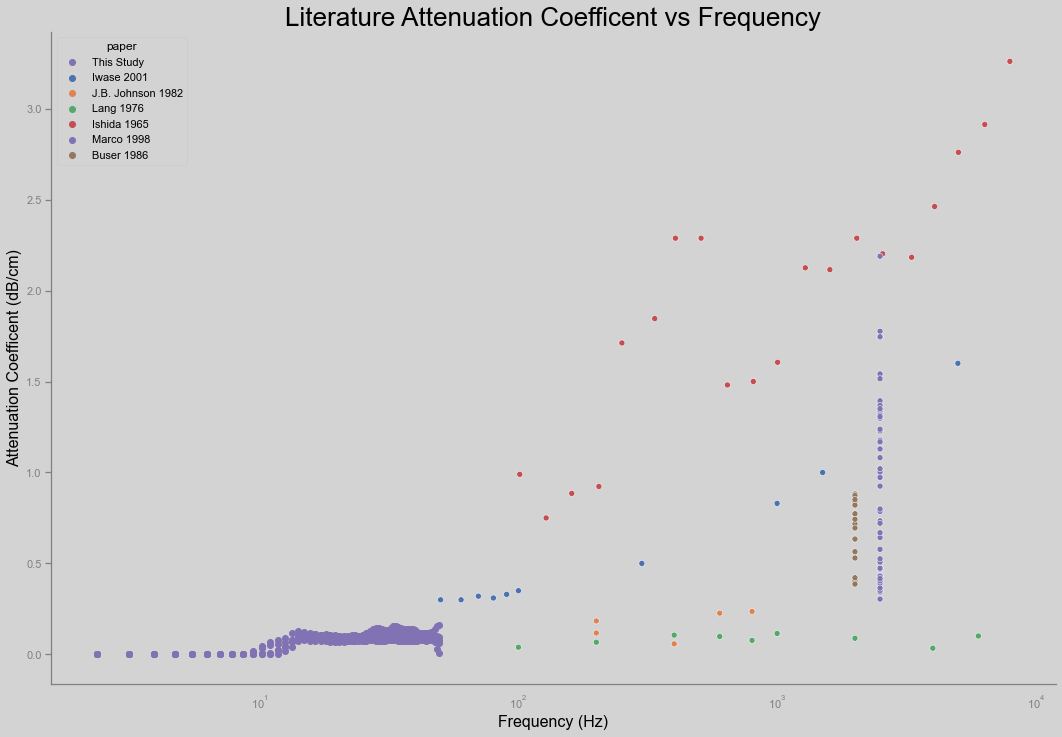

In [6]:
f, ax = plt.subplots()
for i, col in enumerate(ourres.columns):
    if i == 0:
        ax.scatter(ourres.index, ourres[col], color = 'C4', label = 'This Study')
    else:
        ax.scatter(ourres.index, ourres[col], color = 'C4')
sns.scatterplot(x = 'freq', y = 'attcoef', hue = 'paper', data = df, ax = ax)
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation Coefficent (dB/cm)')
plt.title('Literature Attenuation Coefficent vs Frequency')

In [7]:
with open('/Users/zachkeskinen/Documents/infrasound/data/literature/attcoef_mean.pkl', 'rb') as f:
    ourmean = pickle.load(f)
ourmean = ourmean[ourmean.index < 50]

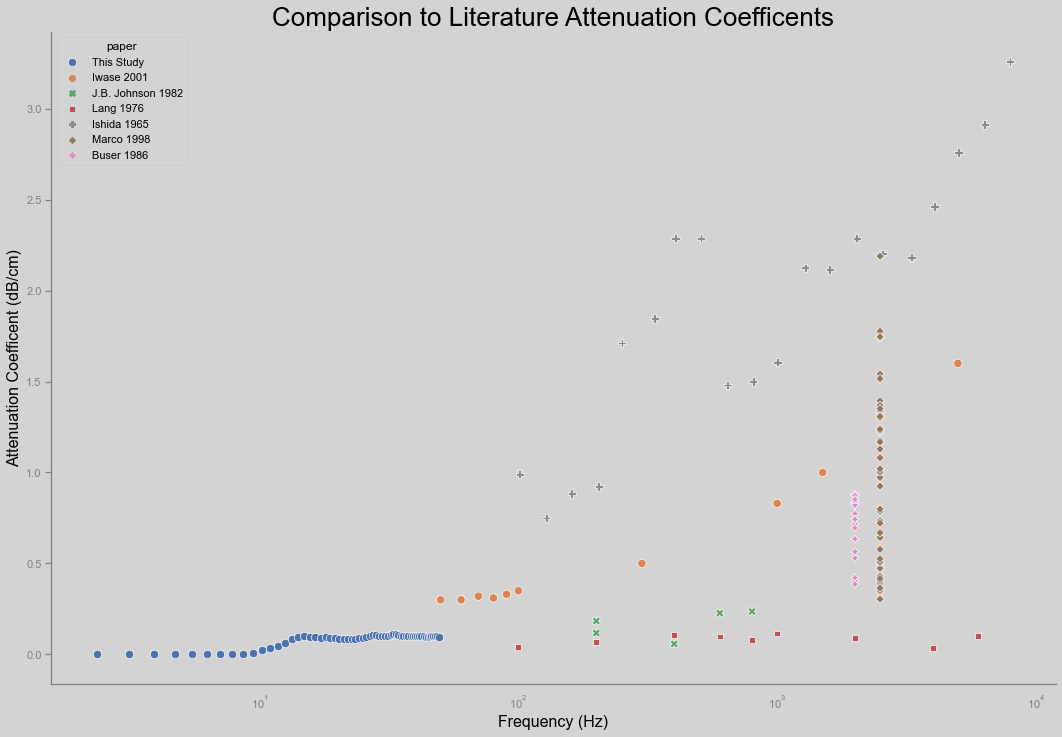

In [8]:
f, ax = plt.subplots()
sns.scatterplot(data = ourmean, label = 'This Study', color = 'C0', marker = 'o', s = 70)
sns.scatterplot(x = 'freq', y = 'attcoef', hue = 'paper', style = 'paper', data = df, ax = ax, s= 70, palette = ['C1','C2','C3','C7','C5','C6'])
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation Coefficent (dB/cm)')
plt.title('Comparison to Literature Attenuation Coefficents')
plt.savefig('/Users/zachkeskinen/Documents/infrasound/figures/attenuation/ourtolit.png')

## modeled underneath

In [11]:
import sys
import numpy as np
import matplotlib.pyplot as plt
path=r'/Users/zachkeskinen/Documents/infrasound/src/biots'  # change me
sys.path.append(path)
from Biot_model import wavenumber

In [12]:
##### FREQUENCY #####
# frequency 40 Hz
f = 40
# angular frequency
omega = 2*np.pi*f

##### AIR PARAMETERS
# Density
p_air = 1.1
# Compressibility
C_air = 1.3e-5
# Viscosity
nu_air = 8.5e-6

##### ICE PARAMETERS #####
# Density
p_ice = 917
# Bulk modulus
K_ice = 1.19e9
# Compressibility
C_ice = 1/K_ice

##### SNOW PARAMETERS #####
# Density (kg/m3)  - from field average
p_snow = 294
# Youngs Modulus of snow
youngs = 2.5e7      # There was a typo in the paper during publications. E=0.2-10**4 MPa. Sorry for that.
# Poissons of snow
poissons = 0.25
# Shear modulus of snow
shear = youngs/(2*(1+poissons))
# radius (assumes sphere)
r = 0.5
# Porosity (0.45- 0.95)
phi = 1 - (p_snow/p_ice)
# Tortuosity with r = 1/2 for sphere
t = 1 - (r*(1- (1/phi)))

# free parameters to vary:
# Permeability
k_snow = 30e-4               # Value form table 1 in Capelli et al. 2016. There are different definitions of permeability. 
# k_snow = 2.7e-8/nu_air
                            # I mixed them in the paper. Sorry for that 
                            # See function header: permeability (definition of Johnson), per=per'(m^2)/dinamic viscosity(mu)
                                                                                 
# Pore characteristic size
d = 0.00032

# Stucture Factor
d_bar = 1

##### CREATING MATERIALS #####
# air = [density, kinetic velocity, compressibility]
air = [p_air, C_air,nu_air]
# ice = [density, compressibility]
ice = [p_ice, C_ice]
# snow = [density, youngs modulus, shear modulus, permeability, pore characteristic size, structure factor, tortuosity factor]
snow = [p_snow, youngs, shear, k_snow, d, d_bar, t]

# running model
[delta1, delta2, delta3] = wavenumber(omega = omega, air = air, ice = ice, snow = snow)

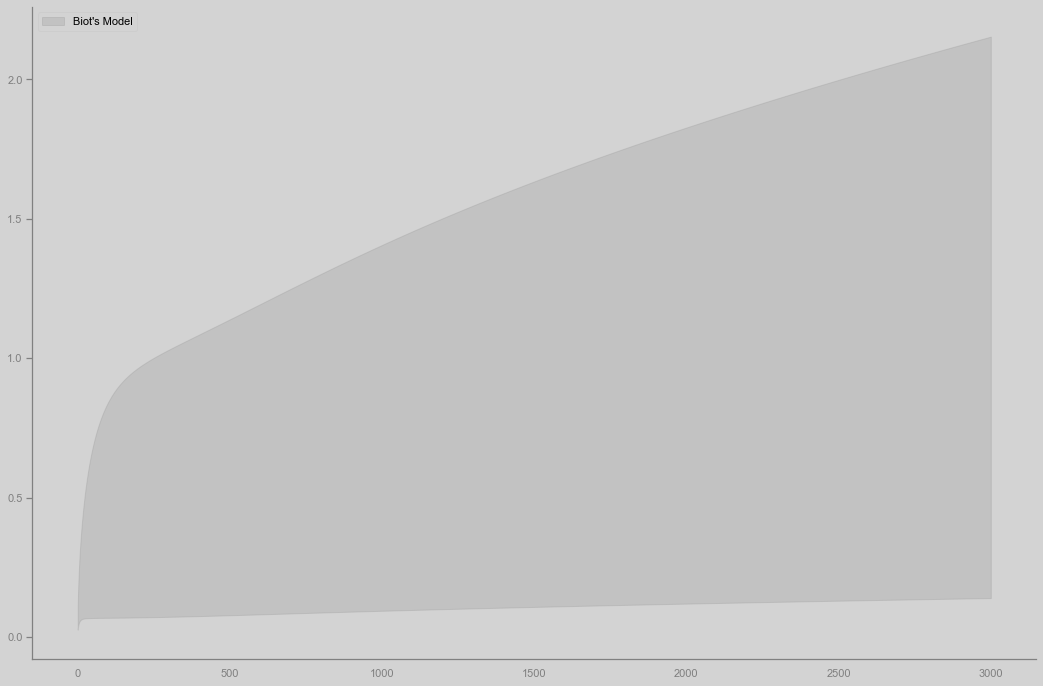

In [77]:
f, ax = plt.subplots()
fs=np.linspace(1,3000,10000)
omegas=2*np.pi*fs
d_bar = 1


pore = pores[0]
perm = perms[0]
snow = [p_snow, youngs, shear, perm, pore, d_bar, t]
ks=wavenumber(omega = omegas, air = air, ice = ice, snow = snow)
alphas_low=-20*np.imag(ks[1])/np.log10(np.e)/100
# l1 = ax.plot(fs, alphas_low, color = 'black', linewidth = 1)

pore = pores[0]
perm = perms[-1]
snow = [p_snow, youngs, shear, perm, pore, d_bar, t]
ks=wavenumber(omega = omegas, air = air, ice = ice, snow = snow)
alphas_high=-20*np.imag(ks[1])/np.log10(np.e)/100
# l2 = ax.plot(fs, alphas_high, color = 'black', linewidth = 1)

ax.fill_between(fs, alphas_low, alphas_high, alpha = 0.2, color = 'gray', label = "Biot's Model")

plt.legend(loc = 'upper left')

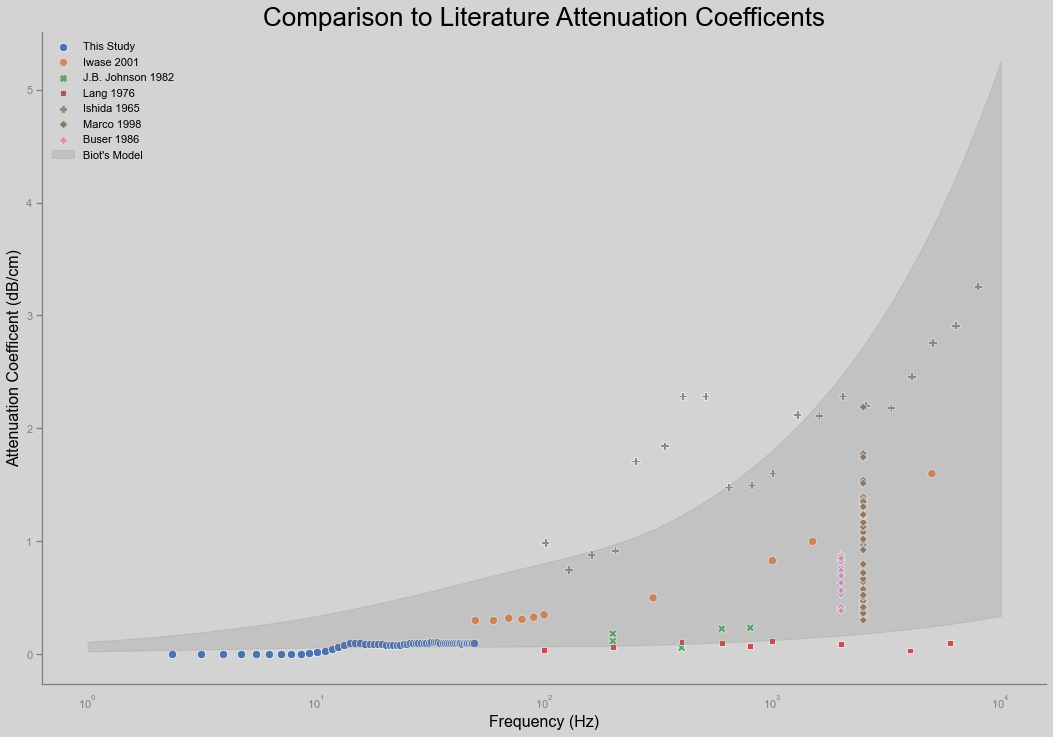

In [81]:
f, ax = plt.subplots()
sns.scatterplot(data = ourmean, label = 'This Study', color = 'C0', marker = 'o', s = 70)
sns.scatterplot(x = 'freq', y = 'attcoef', hue = 'paper', style = 'paper', data = df, ax = ax, s= 70, palette = ['C1','C2','C3','C7','C5','C6'])
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation Coefficent (dB/cm)')
plt.title('Comparison to Literature Attenuation Coefficents')

fs=np.linspace(1,10000,100000)
omegas=2*np.pi*fs
d_bar = 1


pore = pores[1]
perm = perms[0]
snow = [p_snow, youngs, shear, perm, pore, d_bar, t]
ks=wavenumber(omega = omegas, air = air, ice = ice, snow = snow)
alphas_high=-20*np.imag(ks[1])/np.log10(np.e)/100
# l1 = ax.plot(fs, alphas_low, color = 'black', linewidth = 1)

pore = pores[1]
perm = perms[-1]
snow = [p_snow, youngs, shear, perm, pore, d_bar, t]
ks=wavenumber(omega = omegas, air = air, ice = ice, snow = snow)
alphas_low=-20*np.imag(ks[1])/np.log10(np.e)/100
# l2 = ax.plot(fs, alphas_high, color = 'black', linewidth = 1)
# alphas_high[9500:] = alphas_high[9500]
ax.fill_between(fs, alphas_low, alphas_high, alpha = 0.2, color = 'gray', label = "Biot's Model")

plt.legend(loc = 'upper left')

plt.savefig('/Users/zachkeskinen/Documents/infrasound/figures/attenuation/ourtolit_wBiots.png')